In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.models import Model
from keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
%matplotlib inline

C:\Users\Tanvir\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
df = pd.read_csv('dataprep.csv')
df.head()

Label                                          Statement
0     H  @Grumpy_P_Sloth @deanesmay feminists argue for...
1     H  1948Army of England helped the Jews to occupy ...
2     H  Dutch Leader Says Europe to collapse In 6 Week...
3     H  RT @__DeLay: The next day the Romans and the J...
4     H  RT @Bakersman_Joe: When Hitler Invited The Jew...

Text(0.5,1,'Number of H and N messages')

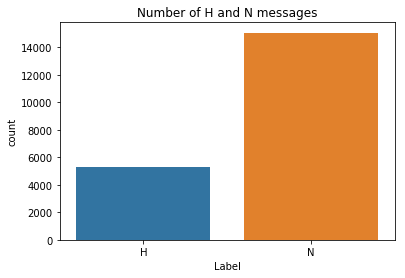

In [3]:
sns.countplot(df.Label)
plt.xlabel('Label')
plt.title('Number of H and N messages')

In [4]:
X = df.Statement
Y = df.Label
le = LabelEncoder()
Y = le.fit_transform(Y)
Y = Y.reshape(-1,1)

In [5]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.20)

In [6]:
max_words = 20000
max_len = 150
tok = Tokenizer(num_words=max_words)
tok.fit_on_texts(X_train)
sequences = tok.texts_to_sequences(X_train)
sequences_matrix = sequence.pad_sequences(sequences,maxlen=max_len)

In [7]:
from keras.preprocessing.sequence import pad_sequences
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(df['Statement'].values)
X = tokenizer.texts_to_sequences(df['Statement'].values)
X = pad_sequences(X)

In [8]:
from keras import layers
def RNN():
    inputs = Input(name='inputs',shape=[max_len])
    layer = Embedding(max_words,50,input_length=max_len)(inputs)
    layer = layers.GRU(100,return_sequences=True)(layer)
    layer = LSTM(512,return_sequences=True)(layer)
    layer = LSTM(256,return_sequences=True)(layer)
    layer = LSTM(128,return_sequences=True)(layer)
    layer = LSTM(64,return_sequences=True)(layer)
    layer = LSTM(32,return_sequences=False)(layer)
    layer = Dense(256,name='FC1')(layer)
    layer = Activation('softmax')(layer)
    layer = Dropout(0.3)(layer)
    layer = Dense(1,name='out_layer')(layer)
    layer = Activation('softmax')(layer)
    model = Model(inputs=inputs,outputs=layer)
    return model

In [9]:
model = RNN()
model.summary()
model.compile(loss='binary_crossentropy',optimizer='RMSprop',metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inputs (InputLayer)          (None, 150)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 150, 50)           1000000   
_________________________________________________________________
gru_1 (GRU)                  (None, 150, 100)          45300     
_________________________________________________________________
lstm_1 (LSTM)                (None, 150, 512)          1255424   
_________________________________________________________________
lstm_2 (LSTM)                (None, 150, 256)          787456    
_________________________________________________________________
lstm_3 (LSTM)                (None, 150, 128)          197120    
_________________________________________________________________
lstm_4 (LSTM)                (None, 150, 64)           49408     
__________

In [10]:
model.fit(sequences_matrix,Y_train,batch_size=64,epochs=10,
          validation_split=0.2,callbacks=[EarlyStopping(monitor='val_loss',min_delta=0.001)])

Train on 13030 samples, validate on 3258 samples
Epoch 1/10
13030/13030 [==============================] - 1959s 150ms/step - loss: 4.1489 - acc: 0.7398 - val_loss: 4.1936 - val_acc: 0.7370
Epoch 2/10
13030/13030 [==============================] - 2371s 182ms/step - loss: 4.1489 - acc: 0.7398 - val_loss: 4.1936 - val_acc: 0.7370


In [11]:
test_sequences = tok.texts_to_sequences(X_test)
test_sequences_matrix = sequence.pad_sequences(test_sequences,maxlen=max_len)

In [12]:
accr = model.evaluate(test_sequences_matrix,Y_test)

4072/4072 [==============================] - 217s 53ms/step


In [13]:
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

Test set
  Loss: 4.060
  Accuracy: 0.745
